In [20]:
!nvidia-smi

Thu Oct 17 18:33:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              29W /  70W |   6255MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/

In [21]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2Tokenizer, AdamW
from transformers import get_linear_schedule_with_warmup

from transformer_lens import HookedTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Read the data
df = pd.read_csv('binary_toxic_classification.csv')

In [6]:
# Hyperparameters
MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-4  # Increased learning rate since we're only training the classifier
THRESHOLD = 0.5
WARMUP_STEPS = 0
MAX_GRAD_NORM = 1.0

In [7]:
# Initialize tokenizer and model
model_name = 'gpt2-medium'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 does not have a pad token, set to eos_token

base_model = HookedTransformer.from_pretrained(model_name)
base_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [8]:
# Define the dataset class
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = ' '.join(text.split())

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
# Split the data (90 % - 10 %)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [10]:
print(f"Train: {train_df.shape}, Valid: {val_df.shape}")

Train: (143613, 2), Valid: (15958, 2)


In [11]:
# Create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ToxicCommentsDataset(
        texts=df['comment_text'].to_numpy(),
        targets=df['toxic_binary'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

In [12]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, TRAIN_BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, VALID_BATCH_SIZE)

In [13]:
# Define the model class
class ToxicCommentClassifier(nn.Module):
    def __init__(self, base_model, n_classes):
        super(ToxicCommentClassifier, self).__init__()
        self.base_model = base_model  # HookedTransformer model
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(base_model.cfg.d_model, n_classes)

        # Freeze GPT-2 parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get hidden states from the base model
        # Unpack outputs and cache
        output = self.base_model.run_with_cache(input_ids, attention_mask=attention_mask)
        last_hidden_state = output[1]['blocks.23.hook_resid_post']  # Assuming 24 layers (0-23)
        # Pool the outputs (mean pooling)
        pooled_output = torch.mean(last_hidden_state, dim=1)
        # Apply dropout and classification layer
        output = self.dropout(pooled_output)
        logits = self.out(output)
        return logits

In [14]:
# Create the model instance
model = ToxicCommentClassifier(base_model=base_model, n_classes=1)
model = model.to(device)

In [15]:
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Since we are only training the classifier head, we can use a higher learning rate
optimizer = AdamW(model.out.parameters(), lr=LEARNING_RATE)

# Note: Only scheduler for the classifier parameters
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# Training function
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training"):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device).unsqueeze(1)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, targets)

        preds = torch.sigmoid(outputs)
        preds = (preds > THRESHOLD).float()
        correct_predictions += torch.sum(preds == targets)

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [17]:
# Evaluation function
def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device).unsqueeze(1)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, targets)

            preds = torch.sigmoid(outputs)
            preds = (preds > THRESHOLD).float()

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples

    # Calculate other metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    return accuracy, np.mean(losses), precision, recall, f1

In [18]:
# Training loop
history = defaultdict(list)
best_f1 = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples=len(train_df)
    )

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss, val_precision, val_recall, val_f1 = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        n_examples=len(val_df)
    )

    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print(f'Val   precision {val_precision:.4f} recall {val_recall:.4f} F1 {val_f1:.4f}')

    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    if val_f1 > best_f1:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_f1 = val_f1
        print(f'Best model saved with F1-score: {best_f1:.4f}')

print(f'\nTraining completed. Best validation F1-score: {best_f1:.4f}')

Epoch 1/3
----------


Training:   0%|          | 0/4488 [00:00<?, ?it/s]

Train loss 0.4459 accuracy 0.9134


Evaluating:   0%|          | 0/499 [00:00<?, ?it/s]

Val   loss 0.1557 accuracy 0.9410
Val   precision 0.8423 recall 0.4952 F1 0.6238
Best model saved with F1-score: 0.6238
Epoch 2/3
----------


Training:   0%|          | 0/4488 [00:00<?, ?it/s]

Train loss 0.1689 accuracy 0.9397


Evaluating:   0%|          | 0/499 [00:00<?, ?it/s]

Val   loss 0.1403 accuracy 0.9466
Val   precision 0.8414 recall 0.5657 F1 0.6765
Best model saved with F1-score: 0.6765
Epoch 3/3
----------


Training:   0%|          | 0/4488 [00:00<?, ?it/s]

Train loss 0.1616 accuracy 0.9414


Evaluating:   0%|          | 0/499 [00:00<?, ?it/s]

Val   loss 0.1384 accuracy 0.9470
Val   precision 0.8342 recall 0.5784 F1 0.6832
Best model saved with F1-score: 0.6832

Training completed. Best validation F1-score: 0.6832


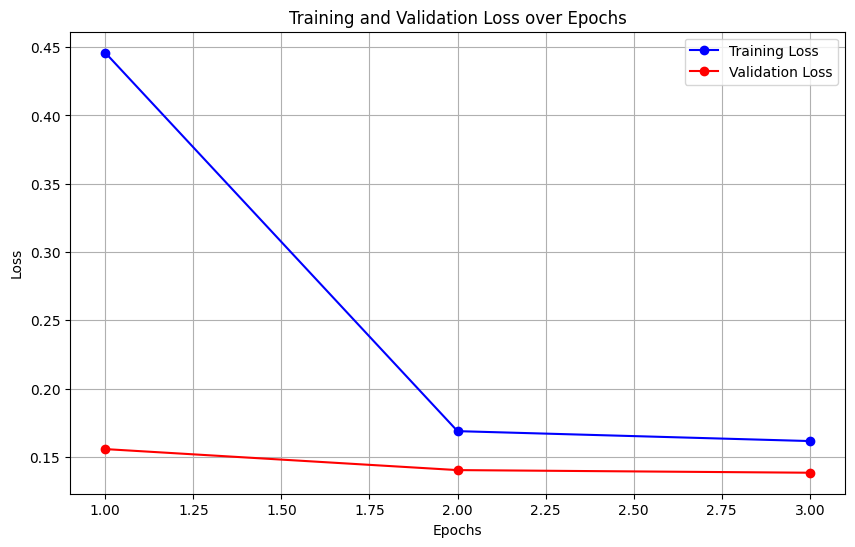

In [25]:
epochs = range(1, len(history['train_loss']) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')  # 'bo-' means blue circle markers with solid line
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')  # 'ro-' means red circle markers with solid line
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('train-val-loss.png')
plt.show()

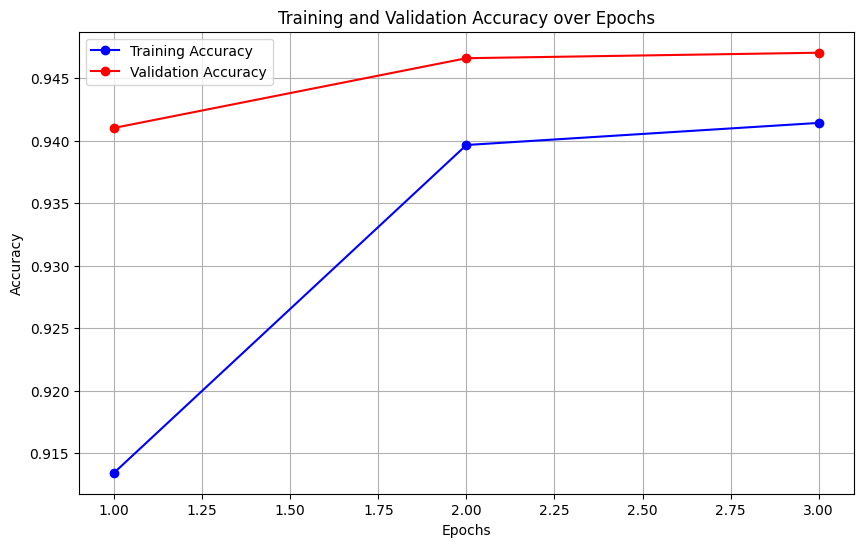

In [26]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('train-val-accuracy.png')
plt.show()

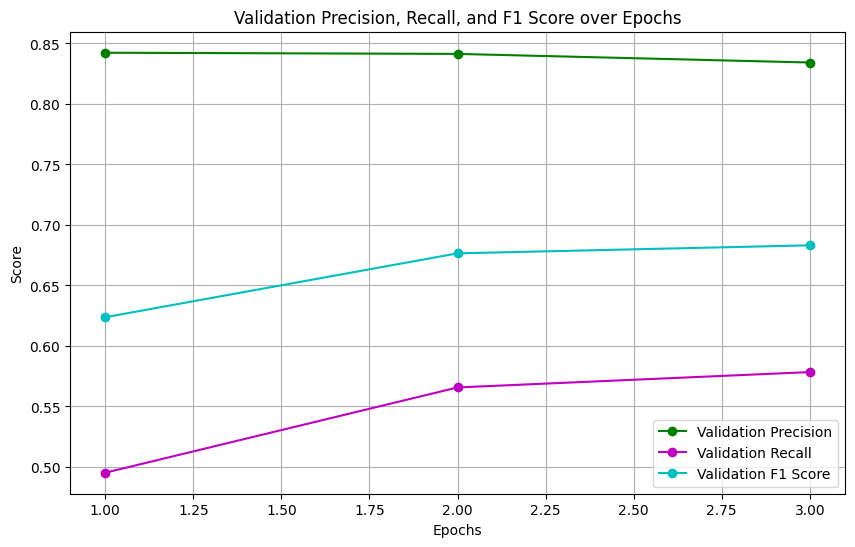

In [27]:
# Plot Validation Precision, Recall, and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['val_precision'], 'go-', label='Validation Precision')  # 'go-' means green circle markers
plt.plot(epochs, history['val_recall'], 'mo-', label='Validation Recall')        # 'mo-' means magenta circle markers
plt.plot(epochs, history['val_f1'], 'co-', label='Validation F1 Score')          # 'co-' means cyan circle markers
plt.title('Validation Precision, Recall, and F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('val-results.png')
plt.show()